# Traffic Sign Classification - LeNet

## Import Libraries

In [68]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.utils import shuffle
from skimage.color import rgb2gray
import os
from sklearn.metrics import confusion_matrix
# Keras Library
from keras.models import Sequential
from keras.layers import Conv2D, Dense, Flatten, AveragePooling2D, BatchNormalization, Dropout
from keras.optimizers import SGD
from keras.callbacks import TensorBoard

## Load Binary Dataset (Pickle)

In [4]:
# Training Data
with open('./datasets/train.p', mode='rb') as file:
    train_data = pickle.load(file)
# Validation Data
with open('./datasets/validation.p', mode='rb') as file:
    validation_data = pickle.load(file)
# Test Data
with open('./datasets/test.p', mode='rb') as file:
    test_data = pickle.load(file)

In [8]:
# Separate Input and Labels from the files loaded
X_train, Y_train = train_data['features'], train_data['labels']
X_validation, Y_validation = validation_data['features'], validation_data['labels']
X_test, Y_test = test_data['features'], test_data['labels']

# Print Data of Input (RGB Images of 32x32 pixels)
print('Dimensions of X_train: ',X_train.shape)
print('Dimensions of X_validation: ',X_validation.shape)
print('Dimensions of X_test ',X_test.shape)

Dimensions of X_train:  (34799, 32, 32, 3)
Dimensions of X_validation:  (4410, 32, 32, 3)
Dimensions of X_test  (12630, 32, 32, 3)
Image Size:  (32, 32, 3)


## Visualize Data (Preliminary Analysis)

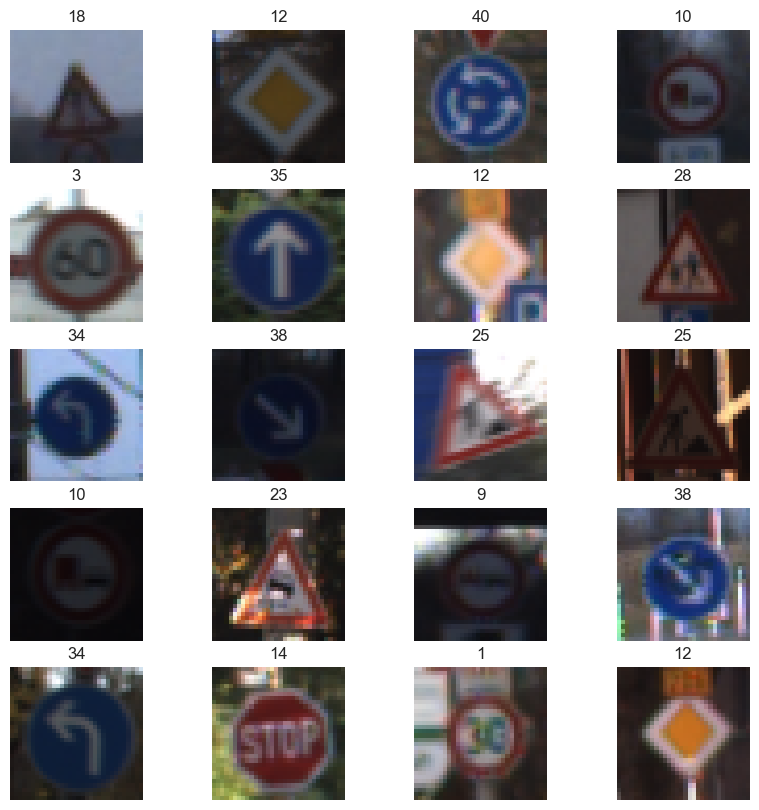

In [12]:
# Create Grid with Images from Train Split
width_grid = 4
height_grid = 5

fig, axes = plt.subplots(height_grid, width_grid, figsize = (10,10))
axes = axes.ravel()

for i in np.arange(0, height_grid * width_grid):
    index_img = np.random.randint(0, len(X_train))
    axes[i].imshow(X_train[index_img])
    axes[i].set_title(Y_train[index_img])
    axes[i].grid(False)
    axes[i].axis('off')

## Data Preparation

In [17]:
# Shuffle Data Loaded
X_train, Y_train = shuffle(X_train, Y_train)
X_validation, Y_validation = shuffle(X_validation, Y_validation )
X_test, Y_test = shuffle(X_test, Y_test)

In [18]:
# Convert from RGB to Grayscale with scikits implementation
X_gray_train = rgb2gray(X_train, channel_axis=3)[..., np.newaxis]
X_gray_test = rgb2gray(X_test, channel_axis=3)[..., np.newaxis]
X_gray_validation = rgb2gray(X_validation, channel_axis=3)[..., np.newaxis]

In [62]:
# Normalize around 0 to [-1, 1]
# Alternative: Subtract mean and divide by STD DEV
X_gray_train_norm = (X_gray_train - 0.5) / 0.5
X_gray_test_norm = (X_gray_test - 0.5)/ 0.5
X_gray_validation_norm = (X_gray_validation - 0.5)/ 0.5

X_gray_train_norm = (X_gray_train - np.mean(X_gray_train)) / np.std(X_gray_train, axis=0)
X_gray_test_norm = (X_gray_test - np.mean(X_gray_test)) / np.std(X_gray_test, axis=0)
X_gray_validation_norm = (X_gray_validation - np.mean(X_gray_validation)) / np.std(X_gray_validation, axis=0)

print('Train Data\n---- Max: ',X_gray_train_norm[0].max(),'\n---- Min: ',X_gray_train_norm[0].min())

Train Data
---- Max:  2.846900399921815 
---- Min:  -0.9532668449024115


## Build Network

In [69]:
cnn_model = Sequential()

cnn_model.add(Conv2D(filters=6, kernel_size=(5,5),activation='relu', input_shape=(32,32,1)))
cnn_model.add(BatchNormalization())
cnn_model.add(AveragePooling2D(pool_size=(2,2))) # Down-sample
cnn_model.add(Dropout(rate=0.4))
cnn_model.add(Conv2D(filters=16, kernel_size=(5,5),activation='relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(AveragePooling2D(pool_size=(2,2))) # Down-sample
cnn_model.add(Dropout(rate=0.4))
cnn_model.add(Flatten())

cnn_model.add(Dense(units=120, activation='relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(Dropout(rate=0.4))
cnn_model.add(Dense(units=84, activation='relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(Dense(units=43, activation='softmax')) # Output Layer

cnn_model.compile(loss='sparse_categorical_crossentropy', optimizer=SGD(learning_rate=0.001, momentum=0.9), metrics=['accuracy'])

cnn_model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 28, 28, 6)         156       
_________________________________________________________________
batch_normalization_5 (Batch (None, 28, 28, 6)         24        
_________________________________________________________________
average_pooling2d_15 (Averag (None, 14, 14, 6)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 10, 10, 16)        2416      
_________________________________________________________________
batch_normalization_6 (Batch (None, 10, 10, 16)        64        
_________________________________________________________________
average_pooling2d_16 (Averag (None, 5, 5, 16)         

In [70]:
# Train
history_epochs = cnn_model.fit(x=X_gray_train_norm,
              y =Y_train,
              batch_size=500,
              epochs=200,
              verbose=1,
              shuffle=True,
              validation_data=(X_gray_validation_norm, Y_validation))

Train on 34799 samples, validate on 4410 samples
Epoch 1/200
34799/34799 [==============================] - 13s 385us/step - loss: 4.1708 - accuracy: 0.0368 - val_loss: 3.7429 - val_accuracy: 0.0277
Epoch 2/200
34799/34799 [==============================] - 13s 360us/step - loss: 3.8623 - accuracy: 0.0676 - val_loss: 3.6784 - val_accuracy: 0.0578
Epoch 3/200
34799/34799 [==============================] - 12s 357us/step - loss: 3.6068 - accuracy: 0.1083 - val_loss: 3.5361 - val_accuracy: 0.0905
Epoch 4/200
34799/34799 [==============================] - 13s 362us/step - loss: 3.3808 - accuracy: 0.1544 - val_loss: 3.3037 - val_accuracy: 0.1503
Epoch 5/200
34799/34799 [==============================] - 13s 365us/step - loss: 3.1391 - accuracy: 0.2048 - val_loss: 3.0113 - val_accuracy: 0.2268
Epoch 6/200
34799/34799 [==============================] - 12s 359us/step - loss: 2.9211 - accuracy: 0.2539 - val_loss: 2.7294 - val_accuracy: 0.2982
Epoch 7/200
34799/34799 [==========================

## Evaluate Model

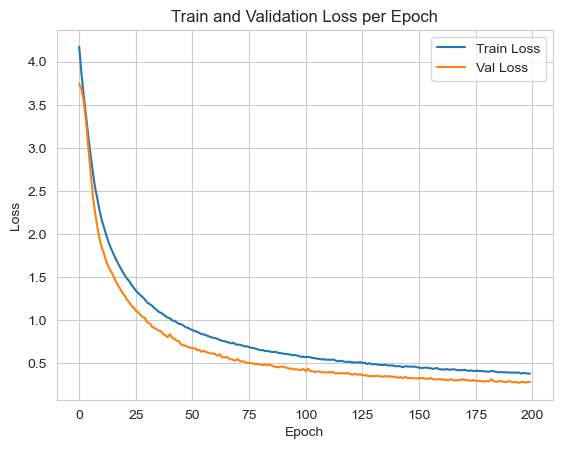

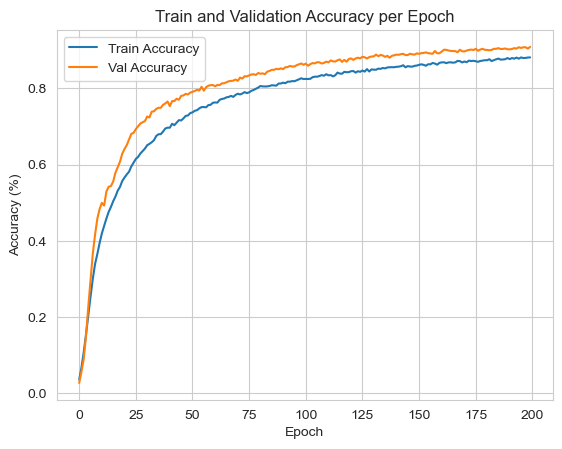

34799/34799 [==============================] - 5s 135us/step
Model Evaluation (Higher is Better): 
--- Train Accuracy: 0.966
--- Test Accuracy: 0.919


In [71]:
# Plot Training Results
plt.figure()
plt.plot(history_epochs.history['loss'])
plt.plot(history_epochs.history['val_loss'])
plt.legend(['Train Loss','Val Loss'])
plt.title('Train and Validation Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

plt.figure()
plt.plot(history_epochs.history['accuracy'])
plt.plot(history_epochs.history['val_accuracy'])
plt.legend(['Train Accuracy','Val Accuracy'])
plt.title('Train and Validation Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.show()

# Evaluation
evaluation_test = cnn_model.evaluate(X_gray_test_norm, Y_test)
evaluation_train = cnn_model.evaluate(X_gray_train_norm, Y_train)
print('Model Evaluation (Higher is Better): \n--- Train Accuracy: %.3f\n--- Test Accuracy: %.3f' % (evaluation_train[1], evaluation_test[1]))

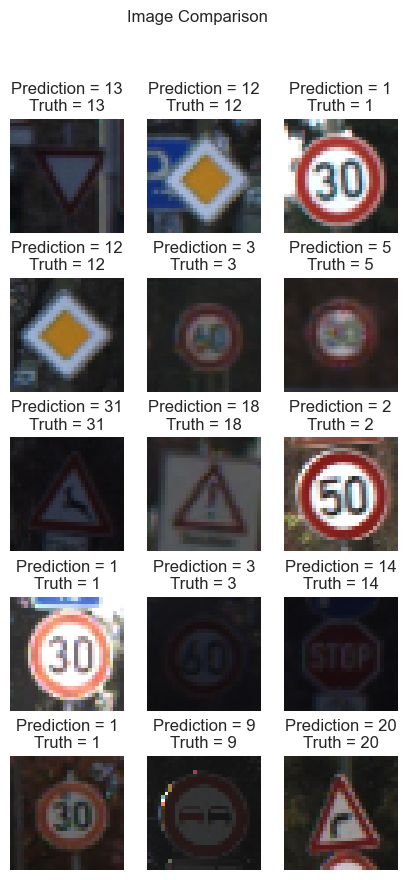

In [72]:
# Create Grid with Images from Train Split
predicted_classes = cnn_model.predict_classes(X_gray_test_norm)
original_class = Y_test
width_grid = 3
height_grid = 5

fig, axes = plt.subplots(height_grid, width_grid,figsize = (5,10))
axes = axes.ravel()
fig.suptitle('Image Comparison')
for i in np.arange(0, height_grid * width_grid):
    index_img = np.random.randint(0, len(X_test))
    axes[i].imshow(X_test[index_img])
    axes[i].set_title('Prediction = {}\nTruth = {}'.format(predicted_classes[index_img],original_class[index_img]))
    axes[i].grid(False)
    axes[i].axis('off')

plt.show()

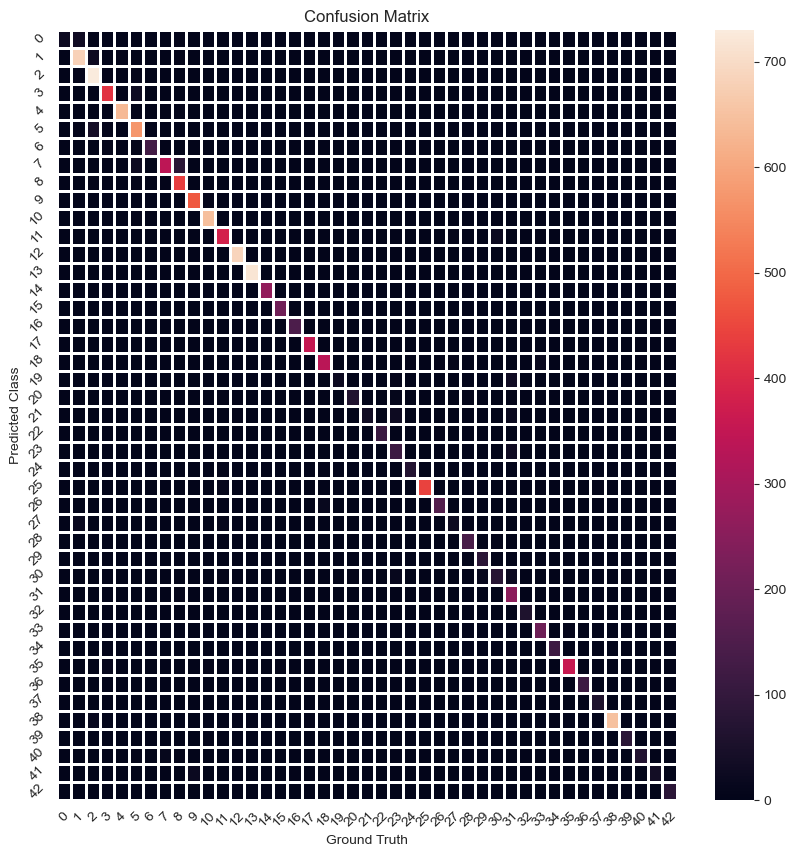

In [74]:
# Plot Confusion Matrix

cm = confusion_matrix(original_class, predicted_classes)
plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=False, linewidths=1)
plt.title('Confusion Matrix')
plt.xlabel('Ground Truth')
plt.ylabel('Predicted Class')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()



## Save Trained Model .h5 file

In [76]:
model_dir = os.path.join(os.getcwd(),'saved_model')

# Make directory if doesn't exist
if not os.path.isdir(model_dir):
    os.makedirs(model_dir)

# Declare model path
model_path = os.path.join(model_dir, 'keras_trained_model.h5')

# Save .h5 model
cnn_model.save(model_path)